<a href="https://colab.research.google.com/github/doeungim/ADP_DE2/blob/main/ADP_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚀 데이터 확인 및 전처리

✅ 1.1 EDA와 시각화 및 통계량 제시

✅ 1.2 변수 선택(VIF), 파생변수 생성, 데이터 분할(train/test(20%)) ,시각화와 통계량을 제시하시오

✅ 1.3 종속변수들중 “1”인지 아닌지 판단하려한다. 종속변수를 1과 1이 아닌 값으로 치환하고 로지스틱 회귀 분석을 실시하라. confusionMatrix를 확인 및 cut off value 정하여라

✅ 1.4 종속변수(y)를 다항(7 class)인 상태에서 SVM을 포함하여 3가지 알고리즘으로 평가하라

✅1.5 종속변수를 제외한 나머지 데이터를 바탕으로 군집분석을 실시하고 최적의 군집수와 군집 레이블을 구하여라. 군집레이블을 추가한 데이터를 1-4에서 만든 모델중 가장 성능이 좋았던 하나의 모델에 다시 학습하여 F1-score를 비교하라

철강데이터 종속변수 : target
데이터 출처 : https://www.kaggle.com/uciml/faulty-steel-plates

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/dataset/ADP_15/problem1.csv')

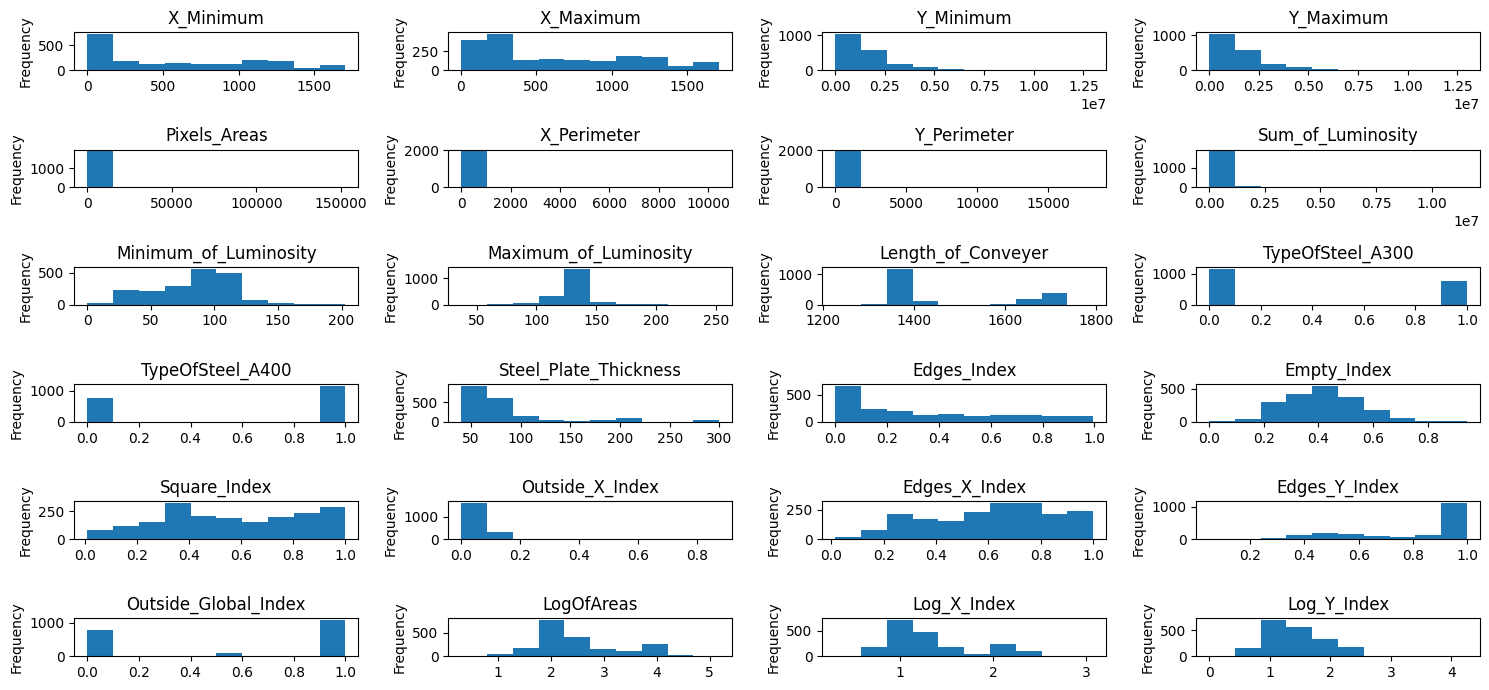


X_Mininukm, Y_Maximum 등 몇몇 데이터가 오른쪽으로 편향된 되어있고,
각 변수는 단위 차이가 존재하는것으로 보아, 변수 변환 및 scaling 의 추가적인 처리가 필요한 것으로 판단된다.




In [3]:
# 1.1 EDA와 시각화 및 통계량 제시

# 1) 데이터 전체 크기
df.shape

# 2) 데이터 종류 - 전체 데이터는 숫자형으로 이루어져있
#df.info()

# 3) 결측치 확인 - 없음
df.isna().sum()

# 4) 기초 통계량
df.describe()

# 5) 분포도 확인

cols = df.columns.difference(['target'])

fig, axes = plt.subplots(6,4, figsize = (15, 7))

for i, axes in enumerate(axes.flat[:]) :

  col_i = df.columns[i]
  df[col_i].plot(kind = 'hist', ax = axes)
  axes.set_title(col_i)

plt.tight_layout()
plt.show()

print("""
X_Mininukm, Y_Maximum 등 몇몇 데이터가 오른쪽으로 편향된 되어있고,
각 변수는 단위 차이가 존재하는것으로 보아, 변수 변환 및 scaling 의 추가적인 처리가 필요한 것으로 판단된다.

""")

In [4]:
max_cols_filter = df.describe().reset_index(drop = True).iloc[6:, :].T
max_cols_filter['diff'] = max_cols_filter[6] - max_cols_filter[7]
display(max_cols_filter.sort_values(by = 'diff', ascending= True).head(10))
print("""
기초 통계량을 확인 해봤을떄, 75%와 max의 값이 큰 차이를 가지는 컬럼 10개를 추출한 결과
아래 10개의 컬럼에서 이상치가 존재할 가능성이 매우 높다.
""")


# 종속변수의 분포 확인
display(df['target'].value_counts().T)
print("Target 변수 또한 불균형이기 떄문에, 차후 분석을 위한 불균형 데이터 처리가 필요해보인다.")

,6,7,diff
Sum_of_Luminosity,83011.0,11591414.0,-11508403.0
Y_Maximum,2183084.0,12987692.0,-10804608.0
Y_Minimum,2183073.0,12987661.0,-10804588.0
Pixels_Areas,822.0,152655.0,-151833.0
Y_Perimeter,83.0,18152.0,-18069.0
X_Perimeter,84.0,10449.0,-10365.0
X_Minimum,1053.0,1705.0,-652.0
X_Maximum,1072.0,1713.0,-641.0
Steel_Plate_Thickness,80.0,300.0,-220.0
Length_of_Conveyer,1650.0,1794.0,-144.0



기초 통계량을 확인 해봤을떄, 75%와 max의 값이 큰 차이를 가지는 컬럼 10개를 추출한 결과
아래 10개의 컬럼에서 이상치가 존재할 가능성이 매우 높다.



,count
target,
7,673
6,402
3,391
2,190
1,158
4,72
5,55


Target 변수 또한 불균형이기 떄문에, 차후 분석을 위한 불균형 데이터 처리가 필요해보인다.


In [5]:
# 1.2 변수 선택(VIF), 파생변수 생성, 데이터 분할(train/test(20%)) ,시각화와 통계량을 제시
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1) VIF 처리

print("""
  VIF 는 다중 공선성을 진단하는 지표로, 독립 변수간의 상관 관계가 높아, 신뢰할 수 없는 회귀 계수를 추정할 수 있거나,
  변동성이 높아져 예측 모델의 안정성이 낮아진다. 과대 혹은 과소 평가 될 수 있어 모델의 해석력을 저하시킨다.
  VIF 가 10 이상인 경우, 심각한 다중 공선성이 존재하는것이 보편적임으로 해당 변수를 제거하며, 다음과 같은 순서로
  작업을 진행한다.
  1. 상관분석을 통한 높은 상관계수를 가지는 컬럼 삭제
  2. 스케일링
  3. VIF 10 이상 초과 컬럼 확인
  4. VIF 컬럼 제거
  5. 최종 컬럼 선택

""")

df_cor = df.corr().unstack().reset_index().rename(columns = {0: 'cor_value'})
over_corr = df_cor[abs(df_cor['cor_value']) >= 0.9]
over_corr = over_corr[over_corr['level_0'] != over_corr['level_1']]
print(over_corr)

print("""
다중 공선성 확인 전, 먼저 상관 계수를 확인하여, 0.8 이상의 컬럼들을 확인하였다.
해당 컬럼들은 VIF 를 확인하기 전, 중복된 변수 혹은 다중 공선성 의심 변수이기 때문에 제거하고, VIF를 실행한다.
""")



  VIF 는 다중 공선성을 진단하는 지표로, 독립 변수간의 상관 관계가 높아, 신뢰할 수 없는 회귀 계수를 추정할 수 있거나,
  변동성이 높아져 예측 모델의 안정성이 낮아진다. 과대 혹은 과소 평가 될 수 있어 모델의 해석력을 저하시킨다.
  VIF 가 10 이상인 경우, 심각한 다중 공선성이 존재하는것이 보편적임으로 해당 변수를 제거하며, 다음과 같은 순서로
  작업을 진행한다.
  1. 스케일링
  2. VIF 10 이상 초과 컬럼 확인
  3. VIF 컬럼 제거


               level_0            level_1  cor_value
1            X_Minimum          X_Maximum   0.988314
28           X_Maximum          X_Minimum   0.988314
59           Y_Minimum          Y_Maximum   1.000000
86           Y_Maximum          Y_Minimum   1.000000
117       Pixels_Areas        X_Perimeter   0.966644
119       Pixels_Areas  Sum_of_Luminosity   0.978952
144        X_Perimeter       Pixels_Areas   0.966644
146        X_Perimeter        Y_Perimeter   0.912436
147        X_Perimeter  Sum_of_Luminosity   0.912956
173        Y_Perimeter        X_Perimeter   0.912436
200  Sum_of_Luminosity       Pixels_Areas   0.978952
201  Sum_of_Luminosity        X_Perimeter   0.912956
320   TypeOfSteel_A300   TypeOfSteel_A400 

✅ Scaler를 적용하기 전에 corr() 확인하는 이유

✅ 올바른 순서 </br>
✔ Step 1: Scaler 적용 전에 corr() 확인하고, 높은 상관성을 가진 변수 제거 </br>
✔ Step 2: Scaler 적용 후 VIF 계산하여 다중공선성이 높은 변수 추가 제거 </br>


📌 상관 계수는 스케일과 무관

✅ 피어슨 상관 계수(Pearson correlation coefficient)는 값의 크기가 아닌 변동 패턴(공분산 기반)으로 계산되므로, Scaler 적용 여부에 큰 영향을 받지 않아
원본 데이터를 기준으로 다중공선성을 확인하는 것이 더 직관적.
Scaler를 적용하면 값이 변형될 가능성 있음

✅ StandardScaler (평균 0, 표준편차 1) → 정규 분포를 따르도록 변환되며, 이상치(outlier)가 큰 영향을 미칠 수 있음 </br>
✅  MinMaxScaler (0~1 정규화) → 데이터의 최소값과 최대값에 따라 조정되므로 상관성이 달라질 가능성이 있음 </br>
✅  RobustScaler (중위수 기반) → 이상치 영향을 줄일 수 있음
📌 , Scaler를 적용한 후에는 corr() 값이 다소 변할 수 있으며, 원래 데이터의 관계를 왜곡할 수 있음. </br>
VIF는 Scaler 적용 후 확인하는 것이 더 적절


다중공선성(VIF, Variance Inflation Factor)을 계산할 때는, 변수가 스케일에 따라 영향을 받을 수 있기 때문에 Scaler 적용 후 계산.
하지만 VIF를 실행하기 전에 높은 상관성을 가지는 변수는 미리 제거하는 것이 좋으므로, corr()은 Scaler 적용 전에 확인


In [8]:
# 상관관계가 0.9이상인 컬럼들을 추출하여 제거한 df를 지정
remove_cols = list(set(over_corr.iloc[:,1].values))
remove_df = df[df.columns.difference(remove_cols)]


# Scaler() - target값을 제거한 독립변수만 추출
vif_df = remove_df.drop(columns = ['target'], axis =1)
ss = StandardScaler()

scale_x = pd.DataFrame(ss.fit_transform(vif_df) , columns = vif_df.columns)


# VIF 확인
vif = pd.DataFrame()
vif['factors'] = [variance_inflation_factor(scale_x.values, i) for i in range(scale_x.shape[1])]
vif['features'] = scale_x.columns
display(vif)
print("Orientation_Index와 Outside_Global_Index 는 완전히 중복된 값일 수 있음으로 제거한다")

,factors,features
0,1.296229,Edges_Index
1,4.882335,Edges_X_Index
2,7.162759,Edges_Y_Index
3,20.836751,Empty_Index
4,1.204282,Length_of_Conveyer
5,839.160254,LogOfAreas
6,387.788443,Log_X_Index
7,269.304235,Log_Y_Index
8,9.487025,Luminosity_Index
9,5.544818,Maximum_of_Luminosity


Orientation_Index와 Outside_Global_Index 는 완전히 중복된 값일 수 있음으로 제거한다


In [9]:
# VIF 10,000 이상 또는 inf 값이 있는 변수 필터링하여 제거한 후 다시 스케일링과 VIF 를 수행한다.
high_vif_features = vif[vif['factors'] > 10000]['features'].tolist()

vif_df_filterd = vif_df.drop(columns = high_vif_features)

ss = StandardScaler()
scaled_x = pd.DataFrame(ss.fit_transform(vif_df_filterd), columns=vif_df_filterd.columns)
vif = pd.DataFrame()
vif['factors'] = [variance_inflation_factor(scaled_x.values, i) for i in range(scaled_x.shape[1])]
vif['features'] = scaled_x.columns
display(vif)
print("""
높은 다중공선성을 가지는 데이터를 선별적으로 제거한 후, 다시 VIF를 실행한 결과, 여전히 10이상의 다중공선성이 존재하는 컬럼들이 있다.
해당 컬럼들을 제거한 변수들을 모델을 위해 선택한 후, final_df로 저장한다
""")

rehigh_vif_features = vif[vif['factors']>10]['features'].tolist()
final_df = vif_df_filterd.drop(columns = rehigh_vif_features)


,factors,features
0,1.296229,Edges_Index
1,4.882335,Edges_X_Index
2,7.162759,Edges_Y_Index
3,20.836751,Empty_Index
4,1.204282,Length_of_Conveyer
5,839.160254,LogOfAreas
6,387.788443,Log_X_Index
7,269.304235,Log_Y_Index
8,9.487025,Luminosity_Index
9,5.544818,Maximum_of_Luminosity



높은 다중공선성을 가지는 데이터를 선별적으로 제거한 후, 다시 VIF를 실행한 결과, 여전히 10이상의 다중공선성이 존재하는 컬럼들이 있다.
해당 컬럼들을 제거한 변수들을 모델을 위해 선택한 후, final_df로 저장한다



In [10]:
## 파생변수 생성 - 새로운 정보를 추가하는 방식으로 파생 변수를 생성한다.
# 1) 비율을 계산하여 관계를 반영한다.

final_df['Edges_XY_ratio'] = final_df['Edges_X_Index'] / final_df['Edges_Y_Index']

# 2) Max와 Min 값의 차이를 계산해준다.
final_df['Diff_Luminosity'] = final_df['Maximum_of_Luminosity'] - final_df['Minimum_of_Luminosity']


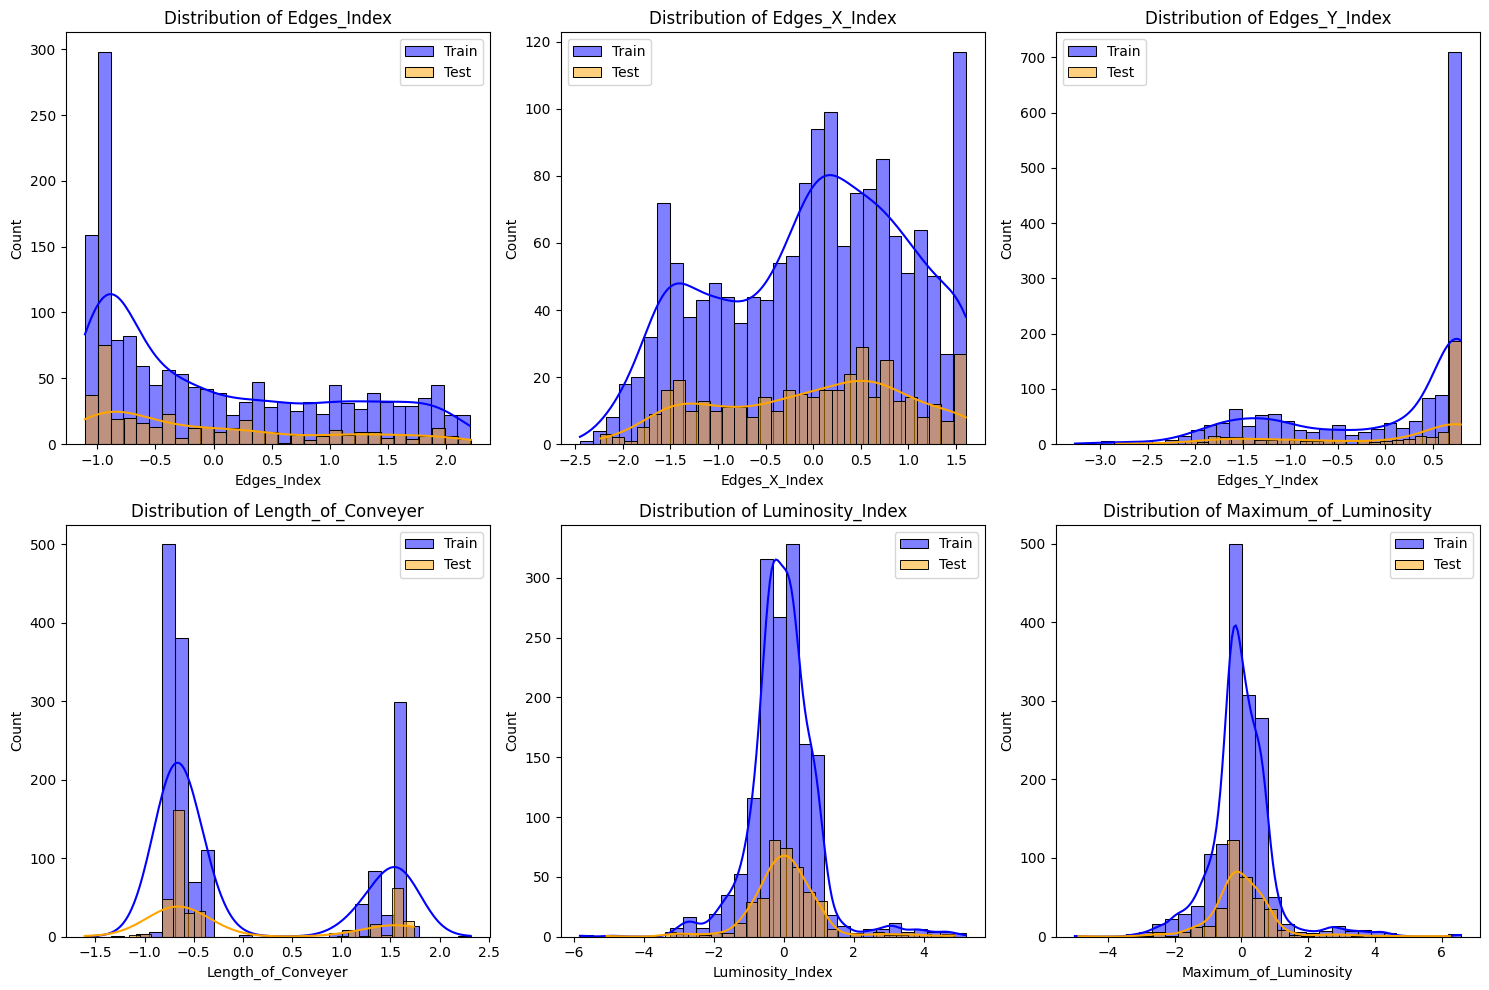


훈련 데이터와 테스트 데이터의 분포가 비슷하게 나타나는것으로보아, 데이터 세트 분할이 제대로 이루어진것으로 확인된다. 



In [36]:
## 데이터 세트 분리
from sklearn.model_selection import train_test_split
import seaborn  as sns


X = final_df.copy()
ss_X = pd.DataFrame(StandardScaler().fit_transform(X), columns = X.columns)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(ss_X, y, test_size = 0.2 , random_state = 1234)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# 주요 Feature 선택 (최대 6개)
selected_features = X_train.columns[:6]  # 6개 변수 선택 (변수 많으면 일부만 시각화)

for i, feature in enumerate(selected_features):
    sns.histplot(X_train[feature], bins=30, kde=True, ax=axes[i], color='blue', label='Train')
    sns.histplot(X_test[feature], bins=30, kde=True, ax=axes[i], color='orange', label='Test')
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].legend()

plt.tight_layout()
plt.show()

print("""
훈련 데이터와 테스트 데이터의 분포가 비슷하게 나타나는것으로보아, 데이터 세트 분할이 제대로 이루어진것으로 확인된다.
""")


In [37]:
# 종속변수들중 “1”인지 아닌지 판단하려한다.
#  종속변수를 1과 1이 아닌 값으로 치환하고 로지스틱 회귀 분석을 실시하라. confusionMatrix를 확인 및 cut off value 정하여라

from sklearn.linear_model  import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc , f1_score

X_train
X_test

# y_train과 y_test를 1,0으로 치환
y_train_log = y_train.apply(lambda x : 1 if x == 1 else 0)
y_test_log = y_test.apply(lambda x : 1 if x == 1 else 0)


# Logistic Model
logi = LogisticRegression()
logi.fit(X_train, y_train_log)

y_pred_proba = logi.predict_proba(X_test)[:,1]
y_pred = logi.predict(X_test)

cm = confusion_matrix(y_test_log, y_pred)
print(classification_report(y_test_log, y_pred))
print("""
Precision 정밀도 : 1이라고 예측한것의 40%만 맞음
Recall 재현율 : 실제 1 중 12%만 맞음
F1-score : 18%로 낮음
전체적으로 낮은 이유는 전체 데이터의 상당 수를 0으로 치환했기 때문이라고 보여짐.

""")

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       355
           1       0.44      0.24      0.31        34

    accuracy                           0.91       389
   macro avg       0.69      0.60      0.63       389
weighted avg       0.89      0.91      0.89       389


Precision 정밀도 : 1이라고 예측한것의 40%만 맞음
Recall 재현율 : 실제 1 중 12%만 맞음 
F1-score : 18%로 낮음 
전체적으로 낮은 이유는 전체 데이터의 상당 수를 0으로 치환했기 때문이라고 보여짐. 




🚀 최적 Cutoff를 찾는 방법

*   TPR-FPR 이 가장 큰 Cutoff 지정
*   Precision-Recall 균형 Cutoff
*   F1-score 최대화 Cutoff 선택



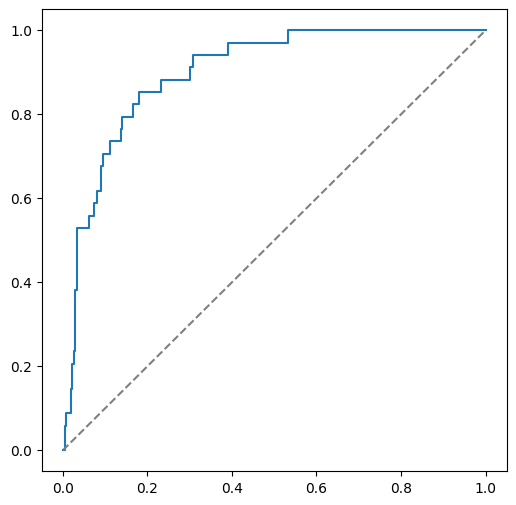

In [38]:
del f1_score  # 잘못된 변수 삭제
from sklearn.metrics import f1_score

# Cuoff value 조정 및 최적의 Cutoff 탐색 - ROC Curve를 보고 최적의 Cutoff를 선택

fpr, tpr , thresholds = roc_curve(y_test_log, y_pred_proba)     # proba - roc 사용
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (6,6))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], color = 'grey', linestyle = '--')
plt.show()

In [39]:

# 1) 최적의 Cutoff 선택하기 - tpr - fpr이 가장 큰 지점을 선택
optimal_idx = np.argmax(fpr - tpr)
optimal_thresholds = thresholds[optimal_idx]
print(f"TPR-FPR Cutoff : {optimal_thresholds}")

# 2) Precision-Recall Curve 기반 최적화 Cutoff
from sklearn.metrics  import precision_recall_curve
precision, recall , threshold = precision_recall_curve(y_test_log, y_pred_proba)

# Precision과 Recall의 차이가 최소인 지점
pc_optimal_idx = np.argmin(abs(precision - recall))
pc_optimal = threshold[pc_optimal_idx]
print(f"Precision-Recall Cutoff : {pc_optimal}")

# 3) F1-score최대의 cutoff
cutoffs = np.linspace(0.1, 0.9, 50)
f1_scores = []

for cutoff in cutoffs :
  y_pred_cutoff = (y_pred_proba >= cutoff).astype(int)
  f1 = f1_score(y_test_log, y_pred_cutoff)
  f1_scores.append(f1)

optimal_f1_idx = cutoffs[np.argmax(f1_scores)]
print(f"Precision-Recall Cutoff : {optimal_f1_idx}")



# Best_Optimal 찾기
ft_optimal = (y_pred_proba >= optimal_thresholds).astype(int)
pc_optimal = (y_pred_proba >= pc_optimal).astype(int)
f1_optimal = (y_pred_proba >= optimal_f1_idx).astype(int)


print(classification_report(y_test_log, ft_optimal))

print(classification_report(y_test_log, pc_optimal))

print(classification_report(y_test_log, f1_optimal))

print("""
TPR-FPR : 정확도가 91로 높지만, 1을 전혀 예측하지 못한다.
Precision-Recall 균형 : 정확도가 90%이며, 정밀도, 재현율이 각각 41%로 균형이 잡혀있다. F1-score또한 41%로 Precision이 과도하게 낮지 않는다.
F1_score 최대화 균형 : 재현율이 0.47로 더 많은 1을 예측 할 수 있으나, 정밀도 보다 높기 때문에 FP(거짓양성)이 높을 수 있기 때문에 편향된 것으로 보인다.

즉, 적절한 Cutoff는 Precison-Recall Cutoff방법과  0.302를 채택한다.
""")

TPR-FPR Cutoff : 0.6818223687649677
Precision-Recall Cutoff : 0.3409607668539584
Precision-Recall Cutoff : 0.3938775510204082
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       355
           1       0.00      0.00      0.00        34

    accuracy                           0.91       389
   macro avg       0.46      0.50      0.48       389
weighted avg       0.83      0.91      0.87       389

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       355
           1       0.53      0.53      0.53        34

    accuracy                           0.92       389
   macro avg       0.74      0.74      0.74       389
weighted avg       0.92      0.92      0.92       389

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       355
           1       0.60      0.53      0.56        34

    accuracy                           0.93       389
  

1.4 종속변수(y)를 다항(7 class)인 상태에서 SVM을 포함하여 3가지 알고리즘으로 평가하라.

##### ✅ 선택할 3가지 알고리즘  

| **알고리즘** | **설명** | **장점** | **단점** |
|-------------|--------|--------|--------|
| **1. SVM (Support Vector Machine)** | 초평면을 이용하여 클래스를 분리하는 커널 기반 분류기 | - 커널 트릭을 통해 비선형 데이터도 분류 가능 <br> <br>- 고차원에서도 성능이 우수 | - 데이터 크기가 커질수록 속도가 느려짐 <br> <br>- 다중 클래스 지원이 제한적 (One-vs-One 필요) |
| **2. Random Forest (랜덤 포레스트)** | 여러 개의 결정 트리를 조합하여 예측하는 앙상블 기법 | - 다중 클래스 분류에서 높은 성능 <br> <br> - 이상치(outlier)와 결측치에 강함 | - 모델 해석이 어려움 (Black-box 모델) <br><br>  - 과적합 가능성이 있음 |
| **3. XGBoost (Extreme Gradient Boosting)** | 부스팅 기법을 활용한 강력한 트리 기반 모델 | - 높은 정확도와 강력한 성능 <br> <br>- 과적합 방지 기능 제공 (Regularization) | - 많은 하이퍼파라미터 튜닝 필요 <br> <br>- 훈련 속도가 느릴 수 있음 |


In [40]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score

X = final_df.copy()
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(ss_X, y, test_size = 0.2 , random_state = 1234)

print(f"{y.value_counts().T} 으로 각 클래스간의 불균형이 존재한다. 그렇기 때문에 F1-score를 평가할때 weighted 를 사용하여 평가한다")

# y 값이 1,2,3,4,5,6 이기 때문에 > 0부터 시작하도록 반환
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

models = {
    "SVM" : SVC(kernel = 'rbf', probability = True) ,
    "Random Forest" : RandomForestClassifier(random_state = 123),
    "XGB" : XGBClassifier(random_state = 42)

}
result = []

# F1-score Options
# macro = 모든 클래스의 F1-score 평균값 : 클래스별 중요도가 같을때
# weighted = 각 클래스의 샘플 수를 고려한 가중 평균 : 클래스의 불균형이 있을때
# micro = 전체 샘플에 대한 Precision & Recall 계산 : 샘플 기반 평가가 필요할때


for name, model in models.items():
  model.fit(X_train, y_train_adjusted)
  y_pred = model.predict(X_test)
  acc_score = accuracy_score(y_test_adjusted, y_pred)
  f1 = f1_score(y_test, y_pred, average = 'weighted')

  result.append([name, acc_score , f1])

print(pd.DataFrame(result,columns=["Model", "Accuracy", "F1-score"]))
print("""
모형 해석
정확도는 XGB 알고리즘이 가장 높은 정확도를 가진다.
하지만 Precison과 Recall의 균형을 평가하는 F1-score가 3가지 알고리즘에 모두 0.1 이하로 매우 낮은 것을 모델이
특정 클래스를 제대로 예측하지 못하고 있다는 것을 보여준다. 클래스 불균형의 문제로 인해, 모델이 많은
클래스 (다수 클래스)는 잘 예측하고, 소수의 클래스는 거의 맞추지 못하는 것으로 보인다.
""")

target
7    673
6    402
3    391
2    190
1    158
4     72
5     55
Name: count, dtype: int64 으로 각 클래스간의 불균형이 존재한다. 그렇기 때문에 F1-score를 평가할때 weighted 를 사용하여 평가한다
           Model  Accuracy  F1-score
0            SVM  0.686375  0.059223
1  Random Forest  0.740360  0.059424
2            XGB  0.763496  0.050796

모형 해석 
정확도는 XGB 알고리즘이 가장 높은 정확도를 가진다. 
하지만 Precison과 Recall의 균형을 평가하는 F1-score가 3가지 알고리즘에 모두 0.1 이하로 매우 낮은 것을 모델이 
특정 클래스를 제대로 예측하지 못하고 있다는 것을 보여준다. 클래스 불균형의 문제로 인해, 모델이 많은 
클래스 (다수 클래스)는 잘 예측하고, 소수의 클래스는 거의 맞추지 못하는 것으로 보인다. 



1.5 종속변수를 제외한 나머지 데이터를 바탕으로 군집분석을 실시하고 최적의 군집수와 군집 레이블을 구하여라. 군집레이블을 추가한 데이터를 1-4에서 만든 모델중 가장 성능이 좋았던 하나의 모델에 다시 학습하여 F1-score를 비교


군집 분석은 거리 기반이기 때문에 표준화가 필수적이다. 모든 변수를 같은 범위로 맞춰야 군집 분석이 잘 수행된다. 



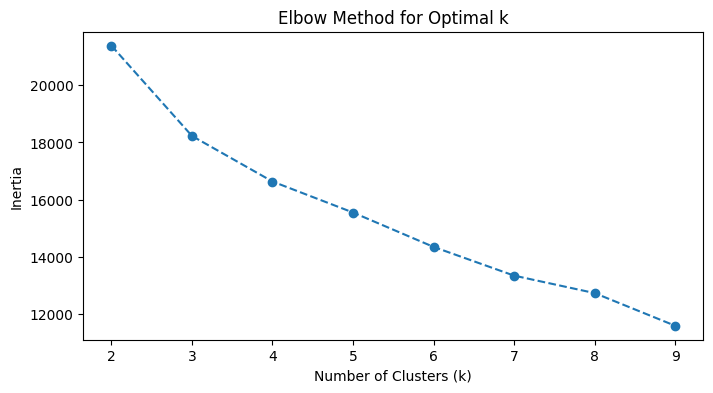

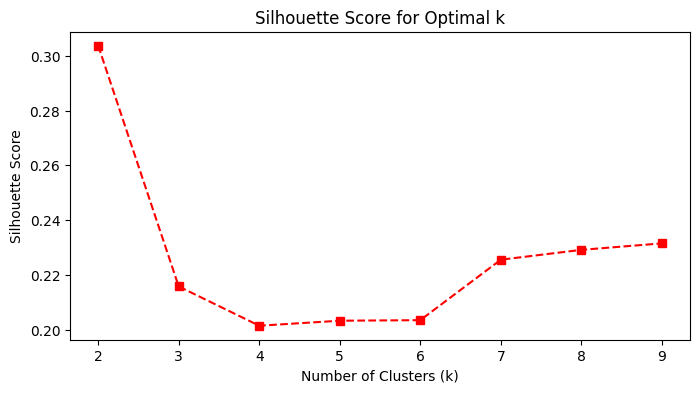


최적의 군집을 찾기 위해, 엘보우와 실루엣 스코어를 추출하였다. 
Elbow에서는 3에서 급격하게 감소한 후, 완만해지는 경향을 보인다.
Silhouette_score 를 보면, K=2 일때 가장 높지만, 일반적으로 3을 고려한다는 점을 가만해야함으로, 
두 가지 점수를 고려해볼때 최적의 군집 수는 3으로 한다. 



In [49]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Scaler 를 사용한 ss_X 사용 :
print("""
군집 분석은 거리 기반이기 때문에 표준화가 필수적이다. 모든 변수를 같은 범위로 맞춰야 군집 분석이 잘 수행된다.
""")

# Elbow / 실루엣 구하기
elbow = []
sil = []
for k in range(2, 10) :
  kmean = KMeans(n_clusters= k)
  kmean.fit(ss_X)
  label = kmean.predict(ss_X)
  # Elbow
  elbow.append(kmean.inertia_)
  # Sillouette
  sil.append(silhouette_score(ss_X, kmean.labels_))


# Elbow Method 시각화
plt.figure(figsize=(8, 4))
plt.plot(range(2,10), elbow, marker='o', linestyle='--')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

# Silhouette Score 시각화
plt.figure(figsize=(8, 4))
plt.plot(range(2,10), sil, marker='s', linestyle='--', color='red')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal k")
plt.show()

print("""
최적의 군집을 찾기 위해, 엘보우와 실루엣 스코어를 추출하였다.
Elbow에서는 3에서 급격하게 감소한 후, 완만해지는 경향을 보인다.
Silhouette_score 를 보면, K=2 일때 가장 높지만, 일반적으로 3을 고려한다는 점을 가만해야함으로,
두 가지 점수를 고려해볼때 최적의 군집 수는 3으로 한다.
""")

In [56]:
optimal_k = 3

Kmean_optimal = KMeans(n_clusters = optimal_k, random_state = 42)
cluster_labels = Kmean_optimal.fit_predict(ss_X)

ss_X['Labels'] = cluster_labels
cluster_X = ss_X.copy()
cluster_y = y.copy() - 1

# 가장 성능이 좋았던 모델 XGBClassifier(random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(cluster_X, cluster_y, test_size = 0.2, random_state = 42)


best_model = XGBClassifier(random_state =42)
best_model.fit(X_train, y_train)
best_y_pred = best_model.predict(X_test)

acc_score = accuracy_score(y_test, best_y_pred)
f1 = f1_score(y_test, best_y_pred, average = 'weighted')

print(f"✅ 기존 XGBoost F1-score: {0.050796}")
print(f"🚀 군집 추가 후 XGBoost F1-score: {f1:.4f}")
print("""
군집 분석 결과를 추가한 내용으로 데이터의 새로운 패턴을 학습하는데 도움이 되었음을 의미한다.
군집을 통해 비슷한 특성을 가지는 데이터를 그룹화하여 학습 성능이 개선되었다.
""")

✅ 기존 XGBoost F1-score: 0.050796
🚀 군집 추가 후 XGBoost F1-score: 0.8004

군집 분석 결과를 추가한 내용으로 데이터의 새로운 패턴을 학습하는데 도움이 되었음을 의미한다. 
군집을 통해 비슷한 특성을 가지는 데이터를 그룹화하여 학습 성능이 개선되었다. 



### 2번 전력 데이터


In [67]:
us = pd.read_csv("https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/dataset/ADP_15/problem2_usage.csv")
history = pd.read_csv("/content/drive/MyDrive/ADP_SONY/ADP_15_데이터세트/problem2_usage_history.csv")

# us 전처리
us['timestamp'] = pd.to_datetime(us['timestamp'], unit= 's')
us2 = us.sort_values('timestamp').reset_index(drop = True)
print(us2['timestamp'].dt.strftime('%H:%M').unique().tolist())

['05:59', '11:59', '17:59', '23:59']


In [77]:

## us
history[history['hh:mm'].isin(['05:59', '11:59', '17:59', '23:59'])]

,hh:mm,6hour_index,A,B,C,D,E
359,05:59,DA_588493,350.9036,401.0326,217.2260,534.7102,150.3872
719,11:59,DA_9340234,835.9658,216.1980,158.5453,144.1320,72.0660
1079,17:59,DA_3352244,234.0609,833.8419,248.6897,117.0304,14.6288
1439,23:59,DA_9075768,162.1927,297.3533,94.6124,716.3510,67.5803
1799,05:59,DA_6294458,269.1807,490.8591,63.3366,142.5075,601.6981
...,...,...,...,...,...,...,...
524159,23:59,DA_6116290,125.7840,67.0849,75.4704,394.1233,167.7121
524519,05:59,DA_5064240,505.7466,82.0129,109.3506,437.4025,218.7012
524879,11:59,DA_8363908,110.4847,501.4306,16.9977,144.4800,67.9906
525239,17:59,DA_7102720,639.6188,232.5887,72.6839,421.5669,72.6840
